# Carga de datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sentence_transformers import SentenceTransformer

df_true = pd.read_csv("True.csv", engine="python", on_bad_lines="skip")
df_fake = pd.read_csv("Fake.csv", engine="python", on_bad_lines="skip")

print(df_true.shape)
print(df_fake.shape)

df_true.head()

(20054, 4)
(19569, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_true["label"] = 1
df_fake["label"] = 0

# Unimos datasets
df = pd.concat([df_true, df_fake], axis=0)

# Barajamos
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,title,text,subject,date,label
0,Trump announces new hires to expand campaign o...,(Reuters) - Presumptive Republican nominee Don...,politicsNews,"June 21, 2016",1
1,HAWAIIAN RESTAURANT Gets Hammered With Negativ...,Honolulu s Caf 8 gets rave reviews on Yelp...,left-news,"Dec 27, 2016",0
2,Cuba’s Raul Castro meets with U.S. Chamber of ...,HAVANA (Reuters) - The head of the U.S. Chambe...,politicsNews,"January 14, 2017",1
3,VA chief presses Congress to make it easier to...,WASHINGTON (Reuters) - Veterans Affairs Secret...,politicsNews,"May 31, 2017",1
4,Senator Grassley expresses reservations on two...,WASHINGTON (Reuters) - The Republican chairman...,politicsNews,"December 12, 2017",1


In [ ]:
df.shape

(39623, 5)

In [ ]:
df["label"].value_counts()

,count
label,
1,20054
0,19569


# EDA

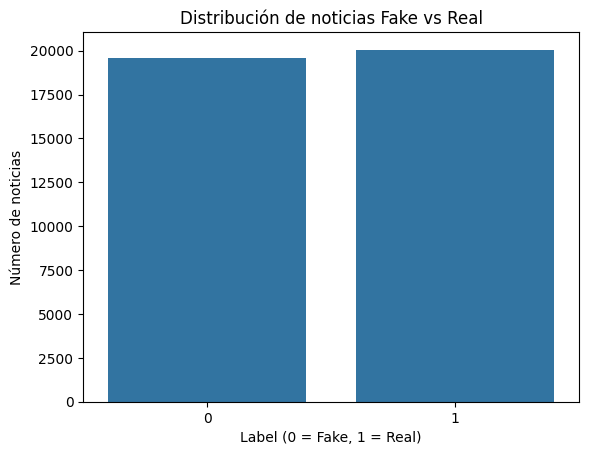

In [ ]:
sns.countplot(x="label", data=df)
plt.title("Distribución de noticias Fake vs Real")
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Número de noticias")
plt.show()

        text_length    word_count
count  39058.000000  39058.000000
mean    2425.340545    398.426622
std     1739.835873    282.583814
min        5.000000      1.000000
25%     1330.000000    219.000000
50%     2224.000000    368.000000
75%     3093.000000    511.000000
max    49705.000000   7033.000000


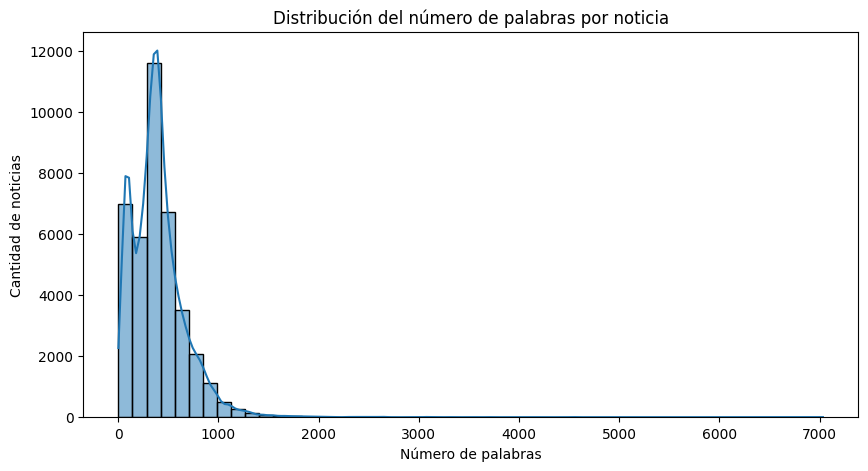

In [ ]:
df['text_length'] = df['text'].apply(len)

# Número de palabras
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print(df[['text_length', 'word_count']].describe())

# Visualizar histograma de longitud de palabras
plt.figure(figsize=(10,5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribución del número de palabras por noticia")
plt.xlabel("Número de palabras")
plt.ylabel("Cantidad de noticias")
plt.show()

In [ ]:
# Eliminar textos vacíos
df = df[df['word_count'] > 0].copy()

df = df.reset_index(drop=True)

print("Nuevo tamaño del dataset:", df.shape)

Nuevo tamaño del dataset: (39058, 7)


# Preprocesamiento

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

df['full_text'] = df['title'] + " " + df['text']

def clean_text(text):
    text = text.lower()  # pasamos a minúsculas
    text = re.sub(r'http\S+','', text)  # quitamos URLs
    text = re.sub(r'[^a-z\s]', '', text)  # quitamos puntuación y números
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['full_text'].apply(clean_text)
df[['full_text','clean_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,full_text,clean_text
0,Trump announces new hires to expand campaign o...,trump announces new hire expand campaign opera...
1,HAWAIIAN RESTAURANT Gets Hammered With Negativ...,hawaiian restaurant get hammered negative revi...
2,Cuba’s Raul Castro meets with U.S. Chamber of ...,cuba raul castro meet u chamber commerce presi...
3,VA chief presses Congress to make it easier to...,va chief press congress make easier fire worke...
4,Senator Grassley expresses reservations on two...,senator grassley express reservation two trump...


In [ ]:
# Tabla pero con mas caracteres
example_df = df[['full_text','clean_text']].head(5).copy()
example_df['full_text'] = example_df['full_text'].str[:100] + "..."
example_df['clean_text'] = example_df['clean_text'].str[:100] + "..."

display(example_df.style.set_caption("Tabla: Ejemplo resumido de textos originales y limpios")
        .set_properties(**{'text-align': 'left'}))

,full_text,clean_text
0,Trump announces new hires to expand campaign operations (Reuters) - Presumptive Republican nominee D...,trump announces new hire expand campaign operation reuters presumptive republican nominee donald tru...
1,HAWAIIAN RESTAURANT Gets Hammered With Negative Reviews After BANNING Trump Supporters: “You cannot ...,hawaiian restaurant get hammered negative review banning trump supporter cannot eat honolulu caf get...
2,Cuba’s Raul Castro meets with U.S. Chamber of Commerce president HAVANA (Reuters) - The head of the ...,cuba raul castro meet u chamber commerce president havana reuters head u chamber commerce met cuban ...
3,VA chief presses Congress to make it easier to fire workers for misconduct WASHINGTON (Reuters) - Ve...,va chief press congress make easier fire worker misconduct washington reuters veteran affair secreta...
4,Senator Grassley expresses reservations on two Trump judge nominees WASHINGTON (Reuters) - The Repub...,senator grassley express reservation two trump judge nominee washington reuters republican chairman ...


In [ ]:
example_df = df[['full_text','clean_text']].head(5).copy()
example_df['full_text_len'] = example_df['full_text'].apply(lambda x: len(x.split()))
example_df['clean_text_len'] = example_df['clean_text'].apply(lambda x: len(x.split()))
example_df = example_df[['full_text_len','clean_text_len']]

display(example_df.style.set_caption("Tabla 3: Longitud de textos originales y limpios (número de palabras)")
        .background_gradient(cmap="Blues", axis=1))

# Ejemplo antes vs despues
for i, row in df[['full_text','clean_text']].head(3).iterrows():
    print(f"--- Ejemplo {i+1} ---")
    print("Original:", row['full_text'][:200], "...")
    print("Limpio  :", row['clean_text'][:200], "...\n")


In [ ]:
# Creamos TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

y = df['label']

print("Tamaño TF-IDF:", X_tfidf.shape)

Tamaño TF-IDF: (39058, 10000)


# Entrenamiento

Accuracy: 0.9863031233998976

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3801
           1       0.98      0.99      0.99      4011

    accuracy                           0.99      7812
   macro avg       0.99      0.99      0.99      7812
weighted avg       0.99      0.99      0.99      7812



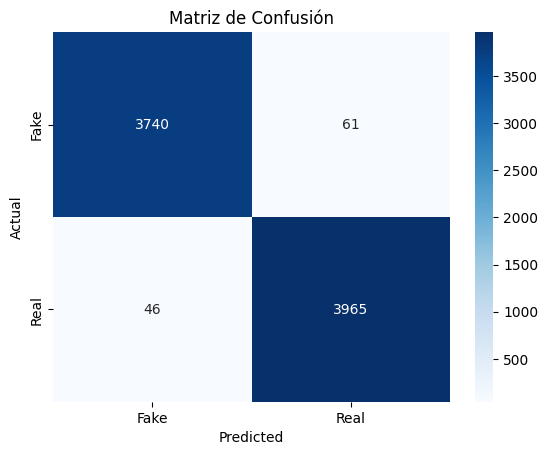

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Creamos y entrenamos modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predecir
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
scores = cross_val_score(clf, X_tfidf, y, cv=5, scoring='accuracy')
print("Accuracy CV (5 folds):", scores)
print("Mean accuracy:", np.mean(scores))

Accuracy CV (5 folds): [0.98758321 0.98796723 0.98604711 0.9833568  0.98847779]
Mean accuracy: 0.9866864268968827


## Sentence transformers

In [ ]:
model = SentenceTransformer('all-MiniLM-L12-v2')
X_emb = model.encode(df['clean_text'], batch_size=64, show_progress_bar=True)

y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamos modelo
clf_emb = LogisticRegression(max_iter=1000)
clf_emb.fit(X_train, y_train)

# Predecir
y_pred = clf_emb.predict(X_test)

print("Accuracy (embeddings):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Batches:   0%|          | 0/611 [00:00<?, ?it/s]

Accuracy (embeddings): 0.9604454685099847

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      3801
           1       0.96      0.97      0.96      4011

    accuracy                           0.96      7812
   macro avg       0.96      0.96      0.96      7812
weighted avg       0.96      0.96      0.96      7812



## Validación cruzada con embeddings

In [ ]:
# Logistic regression sobre embeddings
clf_emb_cv = LogisticRegression(max_iter=1000)

# 5-fold cross-validation
scores_emb = cross_val_score(clf_emb_cv, X_emb, y, cv=5, scoring='accuracy')
print("Accuracy CV embeddings (5 folds):", scores_emb)
print("Mean accuracy embeddings:", np.mean(scores_emb))